# Binary classification test

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import seaborn as sns

## Introduction



```
# This is formatted as code
```

Binary predictors are a key tool in classification problems. These predictors are central to a variety of applications, from disease diagnosis to financial forecasting. In this computer lab, we will attempt to assess the quality of a set of binary predictors on balanced and unbalanced datasets using the quality estimators and metrics we defined in the previous class.

## Experimental setup

We will create an artificial dataset with two clusters in high dimensions. We will assign a label 0 and 1 to each of these clusters and the goal is to evaluate the performance of different predictors to classify which entry belongs to each cluster. In the lab, we will firstly evaluate the quality of the predictions and secondly fine tune the parameters to optimize the performance of each predictor. In the end, we will decide which predictor is the best of all.

We plan to study the following predictors:

#### 1. Random assignment

- **Strategy:** Randomly assign label 1 based on a predefined probability \( p \).
- **Parameter to Tune:** The probability \( p \) of choosing label 1.

#### 2. PCA-based predictor

- **Strategy:** Use principal component analysis (PCA) to assign label 1 based on the first principal component (PC1).
- **Parameter to Tune:** The threshold \( a \) so that label 1 is selected when PC1 < \( a \).

#### 3. Logistic Regression

- **Strategy:** Implement logistic regression to estimate the probability that a given entry belongs to label 1.
- **Tuning parameter:** The threshold for determining the label based on the estimated probability.

---

## Next steps:

1. Define our data set
2. Define the different predictors
3. Define the various quality metrics discussed in the previous class.
4. Evaluate each predictor and optimize the parameters



## 1. Generation of our dataset

We generate 2 random clusters for a binary test classification

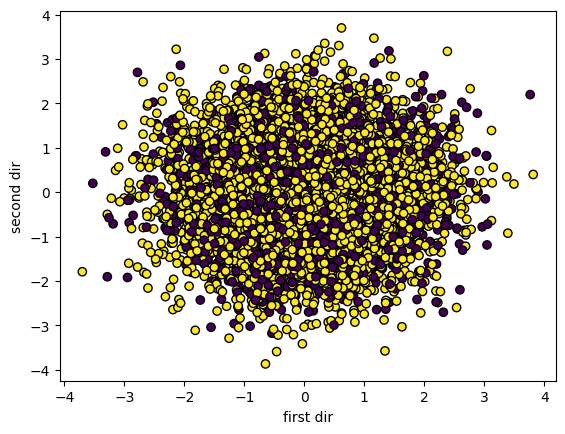

In [3]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Setting the probability for the true class
Prob_true = 0.7

# Generating the n_samples in 20 dimensions belonging to 2 categories
X, y = make_classification(n_features=20,
                           n_samples=10000,
                           n_classes=2,
                           # n_clusters_per_class=1,
                           # class_sep=1.5,
                           weights=[1 - Prob_true, Prob_true],
                           random_state=0
                           )

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

# Plotting the generated data
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, edgecolors='k')
plt.xlabel('first dir')
plt.ylabel('second dir')
plt.show()

We can check that there are two clases of data-points using dimensional reduction, for instance the PCA (we will study its meaning later on in the course)

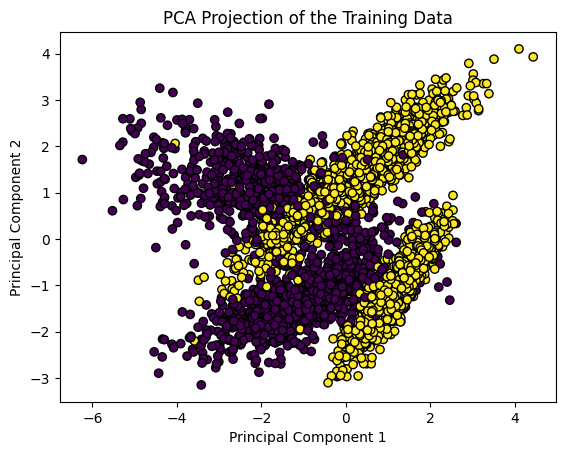

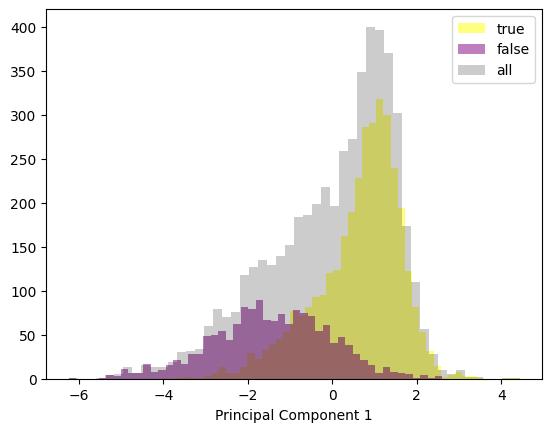

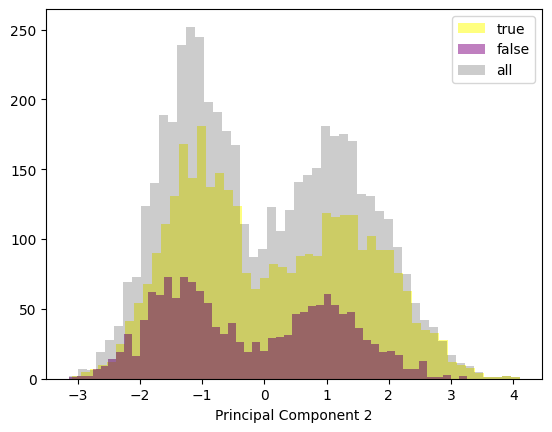

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Plotting the training data in the new PCA space
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], marker='o', c=y_train, edgecolors='k')
plt.title('PCA Projection of the Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

index_1 = (y_train == 1)
index_0 = (y_train == 0)

plt.hist(X_train_pca[index_1, 0], bins=50, color='yellow', alpha=0.5, label='true')
plt.hist(X_train_pca[index_0, 0], bins=50, color='purple', alpha=0.5, label='false')
plt.hist(X_train_pca[:, 0], bins=50, color='black', alpha=0.2, label='all')
plt.legend()
plt.xlabel('Principal Component 1')
plt.show()

plt.hist(X_train_pca[index_1, 1], bins=50, color='yellow', alpha=0.5, label='true')
plt.hist(X_train_pca[index_0, 1], bins=50, color='purple', alpha=0.5, label='false')
plt.hist(X_train_pca[:, 1], bins=50, color='black', alpha=0.2, label='all')
plt.legend()
plt.xlabel('Principal Component 2')
plt.show()

## 2. Define different predictors

We need to define our 3 different predictors.

### No skills

The first predictor is a random guess. We will assign the label 1 to each entry with a probability \( p \).

In [5]:
def no_skills(X, p=0.5):
    return (np.random.rand(len(X)) < p).astype(int) # return a random guess

### Naive: PCA based predictor

The second predictor is based on the first principal component. We will assign the label 1 to each entry with a value of the first principal component smaller than a given threshold.

In [6]:
def PCA_based(X, threshold):
    pca = PCA(n_components=1)
    X_pca = pca.fit_transform(X).reshape(len(X))
    return (X_pca < threshold).astype(int)

### Training: Logistic regression

We can learn to classify this data using logistic regression. I include a discussion about its training, but we do not need this for this lab.

Let us describe the data in terms of a probability function
$$p_{A,B}(\boldsymbol{x})=\frac{1}{1+e^{-(A+\boldsymbol{B}\cdot\boldsymbol{x})}},$$ using labeled data $(\boldsymbol{x}_k,y_k)$. We want to train the model such that the probability $p_k=p_{A,B}(\boldsymbol{x}_k)=1$ for $y_k=1$ and 0 for $y_k=0$. For this purpose, we can define a log loss
$$L=-\sum_{k} y_k\log p_k -(1-y_k)\log p_k $$
(it is clear that $L$ is minimized $p_k=1$ when $y_k=1$ and $p_k=0$ when $y_k=0$).
One can then minimize it by calculating the gradient
$$\frac{\partial L}{\partial A}=\sum_k (p_k-y_k)=0$$
$$\frac{\partial L}{\partial \boldsymbol{B}}=\sum_k \boldsymbol{x}_k (p_k-y_k)=0$$
Which is solved numerically. As a result of this process, we obtain a way to assign to each data point a probability of being in the category $y=1$.

In [7]:
from sklearn.linear_model import LogisticRegression


def logistic(X_test, X_train, y_train):
    clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    return y_pred

## 3. Confusion matrix

Now we have a set of two pairs mutually incompatible events:

- **True cluster** being part of cluster $[0,1]$,
- **Predicted label**: getting $[-,+]$


### Confusion matrices

We need to compute the conditional probablities $P(0|+)$, $P(1|+)$, $P(0|-)$, $P(1|-)$, and the joint probabilities $P(0\cap +)$, $P(1\cap +)$, $P(0\cap -)$, $P(1\cap -)$.

The confusion matrix is a table that is often used to describe the performance of a classification model on a set of data for which the true values are known. The confusion matrix is a 2x2 table with counts of the following events:

- **True Negative (TN)**: The number of correct predictions that an entry is in the negative class.
- **False Positive (FP)**: The number of incorrect predictions that an entry is in the positive class.
- **False Negative (FN)**: The number of incorrect predictions that an entry is in the negative class.
- **True Positive (TP)**: The number of correct predictions that an entry is in the positive class.

We can visualize the confusion matrix as follows:

<table>
    <tr>
        <th></th>
        <th>Pred -</th>
        <th>Pred +</th>
    </tr>
    <tr>
        <th>Real 0</th>
        <td>TN</td>
        <td>FP</td>
    </tr>
    <tr>
        <th>Real 1</th>
        <td>FN</td>
        <td>TP</td>
    </tr>
</table>

**Exercise**: Write a function to compute the entries of the confusion matrix

In [24]:
def compute_confusion_matrix(y_test, y_pred):
    # assign unique int to each case with 2 * y_test + y_pred and count number of occurences with np.bincount:
    # TN = 2 * 0 + 0 = 0
    # FP = 2 * 0 + 1 = 1
    # FN = 2 * 1 + 0 = 2
    # TP = 2 * 1 + 1 = 3
    TN, FP, FN, TP = np.bincount(2 * y_test + y_pred, minlength=4)
    return TN, FP, FN, TP

It is more convenient to divide by the total number of entries to have an idea of the proportions of each case.

<table>
  <tr>
    <th></th>
    <th>Pred -</th>
    <th>Pred +</th>
  </tr>
  <tr>
    <th>Real 0</th>
    <td>TNR </td>
    <td>FPR </td>
  </tr>
  <tr>
    <th>Real 1</th>
    <td>FNR </td>
    <td>TPR</td>
  </tr>
</table>

Such matrix represents the joint probabilities of the events. Here, the letter R stands for ratio, i.e. the proportion of each case. (It is different from the specificity and sensitivity, also called true negative rate and true positive rate, which are conditional probabilities).

**Exercise**:
1. Display the normalized confusion matrix for each of the predictors.
2. Based on the confusion matrices, which predictor is the best? Which predictor is the worst?
3. Considering the random classifier as a *Model baseline*, what can you say about the quality of the two other predictors?

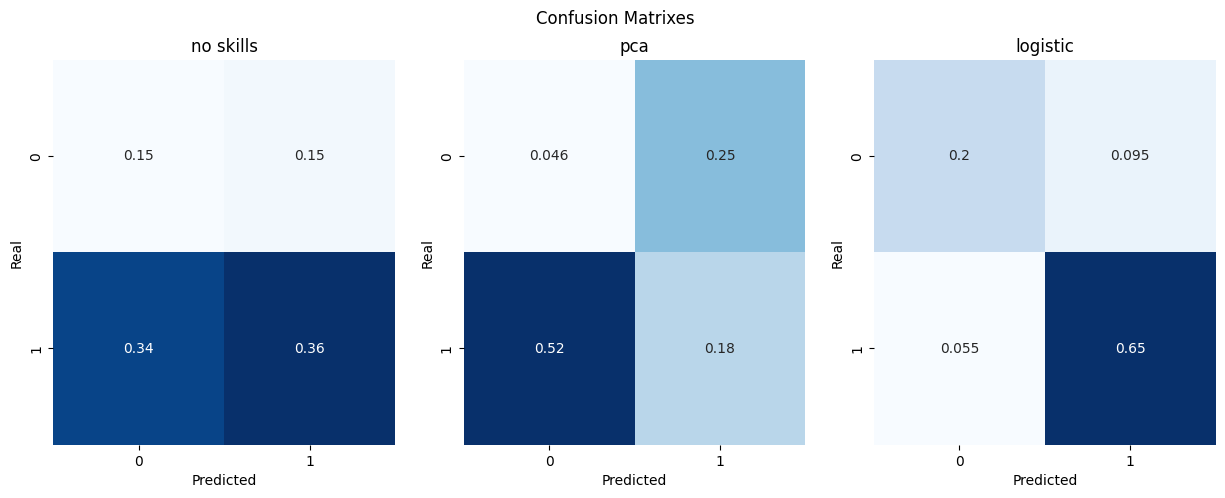

In [30]:
y_pred_r = no_skills(X_test) # no skills
y_pred_pca = PCA_based(X_test, threshold=0) # pca prediction with threshold 0

y_pred_l = logistic(X_test, X_train, y_train) # logistic regression

titles = ['no skills', 'pca', 'logistic']
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, y_pred in enumerate([y_pred_r, y_pred_pca, y_pred_l]):
    TN, FP, FN, TP = compute_confusion_matrix(y_test, y_pred)

    cm = np.array([[TN, FP], [FN, TP]])
    normalized_cm = cm / np.sum(cm)

    ax[i].set_title(titles[i])
    sns.heatmap(cm / np.sum(cm), annot=True, cmap="Blues", cbar=False, ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('Real')
plt.suptitle('Confusion Matrixes')
plt.show()

Answer question 2 and 3 here...

## Random confusion matrix

The random confusion matrix is a special case where the events are assumed to be independent. It is a baseline metric that can be used to evaluate the extent to which the predictors make use of the information in the dataset.

Remember that the independence of events implies the following equalities:

$P(0 \cap +) = P(0)P(+)$

$P(1 \cap +) = P(1)P(+)$

$P(0 \cap -) = P(0)P(-)$

$P(1 \cap -) = P(1)P(-)$

Therefore, the corresponding confusion matrix is:

<table>
  <tr>
    <th></th>
    <th>Pred -</th>
    <th>Pred +</th>
  </tr>
  <tr>
    <th>Real 0</th>
    <td>𝑃(0)𝑃(-)</td>
    <td>𝑃(0)𝑃(+)</td>
  </tr>
  <tr>
    <th>Real 1</th>
    <td>𝑃(1)𝑃(-)</td>
    <td>𝑃(1)𝑃(+)</td>
  </tr>
</table>

**Exercise**: Write a function to compute the random confusion matrix.

In [35]:
def compute_randomconfusion_matrix(y_test, y_pred):
    # p_real = [P(0), P(1)] and p_pred = [P(-), P(+)]
    p_real, p_pred = np.bincount(y_test, minlength=2) / len(y_test), np.bincount(y_pred, minlength=2) / len(y_test)
    
    # compute outer product to get all combinations: [[P(0)P(-), P(0)P(+)], [P(1)P(-), P(1)P(+)]]
    # multiply by length and reshape to 2x2 matrix to get TN, FP, FN and TP
    return np.round(np.outer(p_real, p_pred) * len(y_test)).reshape(2, 2).astype(int)

**Exercise**: Display the normalized confusion matrix for each of the predictors.

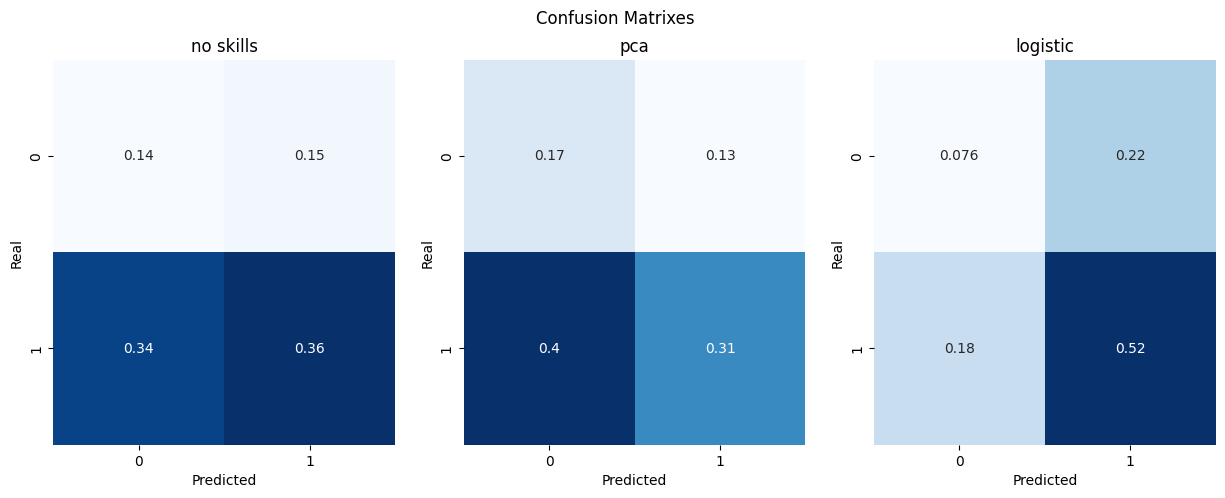

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, y_pred in enumerate([y_pred_r, y_pred_pca, y_pred_l]):
    cm = compute_randomconfusion_matrix(y_test, y_pred)
    normalized_cm = cm / np.sum(cm)

    ax[i].set_title(titles[i])
    sns.heatmap(normalized_cm, annot=True, cmap="Blues", cbar=False, ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('Real')
plt.suptitle('Confusion Matrixes')
plt.show()

**Exercise**: Comparing the random confusion matrix with the confusion matrix of the predictors, what predictor makes best use of the information in the dataset? Which makes the worst use of the information?

Answer here...

## 4. Quality estimators

We can define a set of quality metrics to evaluate the performance of the predictors. These metrics are:

- **Sensitivity (Recall)**: The proportion of actual positive cases that were correctly predicted.
- **Specificity**: The proportion of actual negative cases that were correctly predicted.
- **Precision**: The proportion of predicted positive cases that were correctly predicted.
- **Negative Predictive Value (NPV)**: The proportion of predicted negative cases that were correctly predicted.
- **Accuracy**: The proportion of correct predictions.
- **F1 Score**: The harmonic mean of precision and sensitivity.

**Exercise**:
1. Give a closed-form expression for each of the quality metrics.
2. Define a function to compute each of the quality metrics.
3. Compute the quality metrics for each of the predictors.

### Closed-form expressions:

1. **Sensitivity (Recall)**:

   $$\text{Sensitivity} = \frac{TP}{TP + FN}$$

2. **Specificity**:

   $$\text{Specificity} = \frac{TN}{TN + FP}$$

3. **Precision**:

   $$\text{Precision} = \frac{TP}{TP + FP}$$

4. **Negative Predictive Value (NPV)**:

   $$\text{NPV} = \frac{TN}{TN + FN}$$

5. **Accuracy**:

   $$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

6. **F1 Score**:

   $$\text{F1 Score} = \frac{2 \times \text{Precision} \times \text{Sensitivity}}{\text{Precision} + \text{Sensitivity}} = \frac{2 \times TP}{2 \times TP + FP + FN}$$


In [37]:
def metrics(y_test, y_pred):
    TN, FP, FN, TP = compute_confusion_matrix(y_test, y_pred)
    
    Sen = TP / (TP + FN) if (TP + FN) > 0 else 0
    Spe = TN / (TN + FP) if (TN + FP) > 0 else 0
    Pre = TP / (TP + FP) if (TP + FP) > 0 else 0
    NPV = TN / (TN + FN) if (TN + FN) > 0 else 0
    Acc = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    F1 = (2 * Pre * Sen) / (Pre + Sen) if (Pre + Sen) > 0 else 0

    return Sen, Spe, Pre, NPV, Acc, F1

In [41]:
def metrics_baseline(y_test, y_pred):
    cm = compute_randomconfusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.flatten()
    
    Sen_ran, Spe_ran, Pre_ran, NPV_ran, Acc_ran, F1_ran = metrics(y_test, y_pred)

    return Sen_ran, Spe_ran, Pre_ran, NPV_ran, Acc_ran, F1_ran

In [42]:
def quality_estimators(y_test, y_pred):
    Sen, Spe, Pre, NPV, Acc, F1 = metrics(y_test, y_pred)
    Sen_ran, Spe_ran, Pre_ran, NPV_ran, Acc_ran, F1_ran = metrics_baseline(y_test, y_pred)

    print("**********************")

    print(f"{'Accuracy:':<25} {Acc * 100:.2f}% ({Acc_ran * 100:.2f}%)")
    print(f"{'F1 Score:':<25} {F1:.2f} ({F1_ran:.2f})")
    print(f"{'Sensitivity (Recall):':<25} {Sen * 100:.2f}% ({Sen_ran * 100:.2f}%)")
    print(f"{'Precision:':<25} {Pre * 100:.2f}% ({Pre_ran * 100:.2f}%)")
    print(f"{'Specificity:':<25} {Spe * 100:.2f}% ({Spe_ran * 100:.2f}%)")
    print(f"{'NPV:':<25} {NPV * 100:.2f}% ({NPV_ran * 100:.2f}%)")

    print("**********************")


In [43]:
for i, y_pred in enumerate([y_pred_r, y_pred_pca, y_pred_l]):
    print(titles[i])
    quality_estimators(y_test, y_pred)


no skills
**********************
Accuracy:                 50.56% (50.56%)
F1 Score:                 0.59 (0.59)
Sensitivity (Recall):     51.18% (51.18%)
Precision:                70.45% (70.45%)
Specificity:              49.09% (49.09%)
NPV:                      29.78% (29.78%)
**********************
pca
**********************
Accuracy:                 23.02% (23.02%)
F1 Score:                 0.32 (0.32)
Sensitivity (Recall):     26.13% (26.13%)
Precision:                42.35% (42.35%)
Specificity:              15.64% (15.64%)
NPV:                      8.20% (8.20%)
**********************
logistic
**********************
Accuracy:                 85.00% (85.00%)
F1 Score:                 0.90 (0.90)
Sensitivity (Recall):     92.12% (92.12%)
Precision:                87.26% (87.26%)
Specificity:              68.11% (68.11%)
NPV:                      78.48% (78.48%)
**********************


**Exercise**:
1. Based on the quality metrics, which predictor is the best? Which predictor is the worst?
2. Considering the random classifier as a *Model baseline*, what can you say about the quality of the two other predictors?
3. Based on the quality metrics and the random quality metrics, which predictor makes the best use of the information in the dataset? Which makes the worst use of the information?

## 5. Quality as a function of the parameters

Compute the accuracy of each method as function of the parameters of the predictor. What can you say about the quality of the predictors as a function of the parameters?

**Exercise**:
1. Compute the metrics of each method as a function of the parameters of the predictor.
2. Plot the metrics of each method as a function of the parameters of the predictor.
3. Based on the plot, which predictor is the best? Which predictor is the worst?
4. What can you say about the quality of the predictors as a function of the parameters?

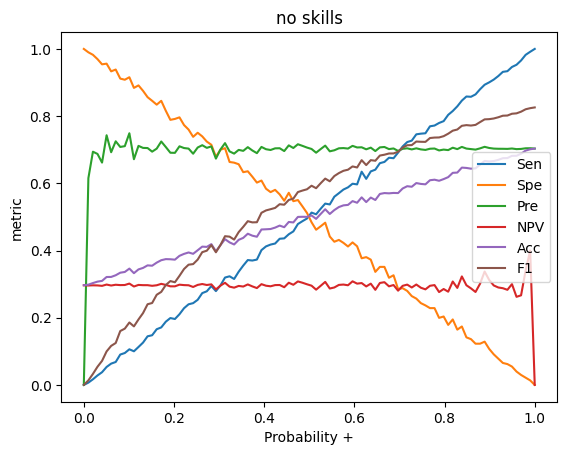

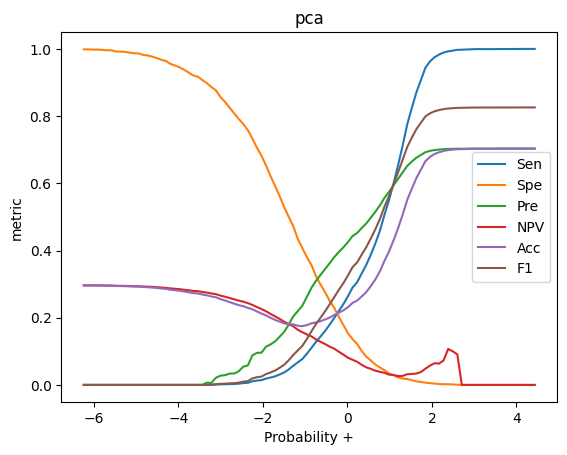

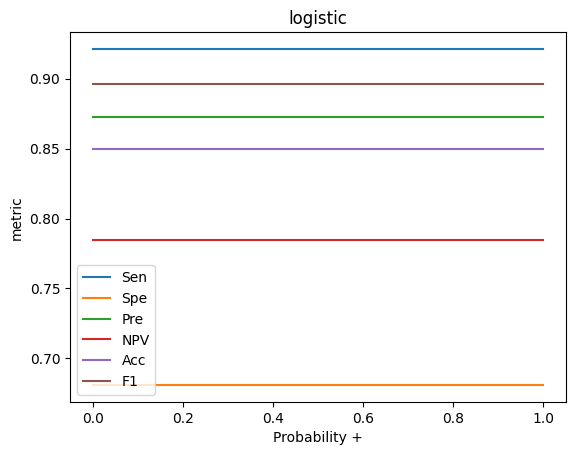

In [44]:
N = 100  # number of parameters

## random

range_noskill = np.linspace(0, 1, N)
Metrics_noskill = np.zeros((N, 6))
for ith, p in enumerate(range_noskill):
    y_pred_th = no_skills(X_test, p=p) # no skills
    Metrics_noskill[ith] = np.nan_to_num(metrics(y_test, y_pred_th))

plt.title(titles[0])
plt.plot(range_noskill, Metrics_noskill[:, 0], label='Sen')
plt.plot(range_noskill, Metrics_noskill[:, 1], label='Spe')
plt.plot(range_noskill, Metrics_noskill[:, 2], label='Pre')
plt.plot(range_noskill, Metrics_noskill[:, 3], label='NPV')
plt.plot(range_noskill, Metrics_noskill[:, 4], label='Acc')
plt.plot(range_noskill, Metrics_noskill[:, 5], label='F1')
plt.xlabel('Probability +')
plt.ylabel('metric')
plt.legend()
plt.show()

## pca


range_pca = np.linspace(np.min(X_train_pca[:, 0]), np.max(X_train_pca[:, 0]), N)
Metrics_pca = np.zeros((N, 6))
for ith, p in enumerate(range_pca):
    y_pred_th = PCA_based(X_test, threshold=p) # pca prediction with threshold p
    Metrics_pca[ith] = np.nan_to_num(metrics(y_test, y_pred_th))

plt.title(titles[1])
plt.plot(range_pca, Metrics_pca[:, 0], label='Sen')
plt.plot(range_pca, Metrics_pca[:, 1], label='Spe')
plt.plot(range_pca, Metrics_pca[:, 2], label='Pre')
plt.plot(range_pca, Metrics_pca[:, 3], label='NPV')
plt.plot(range_pca, Metrics_pca[:, 4], label='Acc')
plt.plot(range_pca, Metrics_pca[:, 5], label='F1')
plt.xlabel('Probability +')
plt.ylabel('metric')
plt.legend()
plt.show()

## logistic

range_log = np.linspace(0, 1, N)
Metrics_log = np.zeros((N, 6))
for ith, p in enumerate(range_log):
    y_pred_th = logistic(X_test, X_train, y_train) # logistic regression
    Metrics_log[ith] = np.nan_to_num(metrics(y_test, y_pred_th))

plt.title(titles[2])
plt.plot(range_log, Metrics_log[:, 0], label='Sen')
plt.plot(range_log, Metrics_log[:, 1], label='Spe')
plt.plot(range_log, Metrics_log[:, 2], label='Pre')
plt.plot(range_log, Metrics_log[:, 3], label='NPV')
plt.plot(range_log, Metrics_log[:, 4], label='Acc')
plt.plot(range_log, Metrics_log[:, 5], label='F1')
plt.xlabel('Probability +')
plt.ylabel('metric')
plt.legend()
plt.show()

range_pca = np.linspace(np.min(X_train_pca[:, 0]), np.max(X_train_pca[:, 0]), N)
